# Data analytics in Python: Scraping and learning from NBA player statistics

#### Alex Wurm

#### August 2022 
#### [Github Repo](https://github.com/aewurm98/alex_wurm_nba_stats_with_python)

## Introduction

I am a huge fan of the NBA, and basketball in general. If you're coming to this project from [my website](https://alexwurm.com/) you may have picked up on that. Starting in 2020, I began developing a stronger interest in technology and data as well. As part of the work I am doing to gain the skills I believe will be useful for being a founder in the tech world, I set out to marry my data skills to a topic I find interesting. 

For this project, I (i) use web-scraping tools such as BeautifulSoup to collect disparate data from espn.com's player pages, (ii) use Python's analytics and modeling tools to draw some interesting insights from this data, and (iii) use Python's predictive modeling capabilities to demonstrate how machine learning can be used to make predictions about NBA players.

I've left commentary throughout this notebook, as well as checkpoints at which you can export the dataset to play around with it yourself.

If any trades / retirements have occured since I posted this project which impact the players used in the examples I've included (e.g., Lebron James, Kevin Durant, Stephen Curry) you may need to edit the 'espn_nba_stats_scrape.py' file in order to replicate the steps detailed below.

If you enjoy this project, let me know! Check out my [website](https://alexwurm.com/) and [Substack](https://alexwurm.substack.com/) to get in touch and see more from me.

## Part 1: Webscraping

### Source: https://www.espn.com/nba/

#### Credit to Erick Lu for some of the ideas here in a similar project back in 2020 (https://erilu.github.io/web-scraping-NBA-statistics/)

#### I originally tried to mimic some of the approach from this project, as shown below; however, the espn.com website has changed in the past few years and that method of scraping the player information is no longer valid

![NBATEAMSPAGE](./images/espn_nba_teams_page.png "NBA teams page on espn.com")

In [122]:
# import packages to allow regex handling of url subdirectories

import re
import urllib
from time import sleep

In [123]:
# create function to compile list of all team roster urls

def scrape_roster_urls():
    # use regex to find all html on ESPN's NBA teams page that points to the teams' rosters
    f = urllib.request.urlopen('http://www.espn.com/nba/teams')
    teams_content = f.read().decode('utf-8')
    teams_list = dict(re.findall("\"/nba/team/roster/_/name/(\w+)/(.+?)\"", teams_content))

    # generate array of urls to scrape
    roster_urls = []
    for key in teams_list.keys():
        roster_urls.append('https://www.espn.com/nba/team/roster/_/name/' + key + '/' + teams_list[key])
        teams_list[key] = str(teams_list[key])
    return dict(zip(teams_list.values(),roster_urls))

In [124]:
# build dictionary of current nba rosters
nba_rosters = scrape_roster_urls()

# display the dictionary keys
nba_rosters.keys()

dict_keys(['boston-celtics', 'brooklyn-nets', 'new-york-knicks', 'philadelphia-76ers', 'toronto-raptors', 'chicago-bulls', 'cleveland-cavaliers', 'detroit-pistons', 'indiana-pacers', 'milwaukee-bucks', 'denver-nuggets', 'minnesota-timberwolves', 'oklahoma-city-thunder', 'portland-trail-blazers', 'utah-jazz', 'golden-state-warriors', 'la-clippers', 'los-angeles-lakers', 'phoenix-suns', 'sacramento-kings', 'atlanta-hawks', 'charlotte-hornets', 'miami-heat', 'orlando-magic', 'washington-wizards', 'dallas-mavericks', 'houston-rockets', 'memphis-grizzlies', 'new-orleans-pelicans', 'san-antonio-spurs'])

#### Upon visiting the roster and player pages on ESPN, I realized the data that was formerly stored in easily accessible json back in 2020 was now distributed throughout identical html table row tags, meaning re.findall wouldn't be a powerful enough tool to extract all of the data I'd need from the website. Therefore, I've replicated the above steps using Beautiful Soup, an HTML parser which would help with more targeted searches in the later steps of this project.

In [125]:
# import beautifulsoup library to help parse the tables where player information is stored
from bs4 import BeautifulSoup, Tag

# create an instance of the beautifulsoup class to parse the page
f = urllib.request.urlopen('http://www.espn.com/nba/teams')
teams_soup = BeautifulSoup(f.read(), 'html.parser')

# define an iterable helper class to pull list of links using regexes
class my_regex_searcher:
    def __init__(self, regex_string):
        self.__r = re.compile(regex_string)
        self.groups = []

    def __call__(self, what):
        if isinstance(what, Tag):
            what = what.name

        if what:
            g = self.__r.findall(what)
            if g:
                self.groups.append(g)
                return True
        return False

    def __iter__(self):
        yield from self.groups

# create instance of regex_searcher for links to roster pages
roster_searcher = my_regex_searcher(r"/nba/team/roster/_/name/(\w+)/(.+)")

# add all roster page links to a dictionary to unpack the regex searcher object
scraped_roster_details = dict(zip(teams_soup.find_all(href=roster_searcher), roster_searcher))

# extract the components of the keys and values in this intermediate dictionary
# and re-zip them together to create the final cleaned dictionary we'll want to use
teams = []
links = []

for value in scraped_roster_details.values():
    teams.append(value[0][1])

for key in scraped_roster_details.keys():
    links.append('https://www.espn.com' + key.get('href'))    

rosters_library = dict(zip(teams,links))

# display the dictionary keys
rosters_library.keys()


dict_keys(['boston-celtics', 'brooklyn-nets', 'new-york-knicks', 'philadelphia-76ers', 'toronto-raptors', 'chicago-bulls', 'cleveland-cavaliers', 'detroit-pistons', 'indiana-pacers', 'milwaukee-bucks', 'denver-nuggets', 'minnesota-timberwolves', 'oklahoma-city-thunder', 'portland-trail-blazers', 'utah-jazz', 'golden-state-warriors', 'la-clippers', 'los-angeles-lakers', 'phoenix-suns', 'sacramento-kings', 'atlanta-hawks', 'charlotte-hornets', 'miami-heat', 'orlando-magic', 'washington-wizards', 'dallas-mavericks', 'houston-rockets', 'memphis-grizzlies', 'new-orleans-pelicans', 'san-antonio-spurs'])

#### The next step in this process involves collecting player data from each of the 'roster' pages of the 30 NBA teams. To accomplish this pull, we need to iterate through the entire page and pull the set of values associated with each table row (player) across all columns.

![NBATEAMPAGE](./images/espn_nba_brooklyn_nets_roster_page.png "Brooklyn Nets roster page on espn.com")

#### You'll notice in the page's html that each row is associated with a numerical index, and that the fixed first column of the table is separate from the rest of the scrollable table columns.

![NBATEAMPAGEHTML](./images/espn_nba_brooklyn_nets_roster_page_inspect.png "Brooklyn Nets roster page html on espn.com")

#### To get the information we want, we'll need to loop through both the header and body sections of the table

In [126]:
# parse table headers
f = urllib.request.urlopen('https://www.espn.com/nba/team/roster/_/name/bkn/brooklyn-nets')
roster_soup = BeautifulSoup(f.read(), 'html.parser')
table_headers = roster_soup.find_all('th', {'class':'Table__TH'})

# convert bs4 result set into string array for regex matching
header_values = []
for x in table_headers:
    header_values.append(str(x))

# extract list of table headers
column_names = []
for x in header_values:

    # append conditionally to avoid blank spacer block at the top left of the tables
    if len(re.findall(">([a-zA-Z]+?)<",header_values[header_values.index(x)])) > 0:
        column_names.append(re.findall(">([a-zA-Z]+?)<",header_values[header_values.index(x)])[0])

column_names

['Name', 'POS', 'Age', 'HT', 'WT', 'College', 'Salary']

#### Now that we have an array to reference for the sets of data we'll be pulling for each player, we can pull the player data.

#### First we'll start with an example for a single player

In [127]:
# parse first row of table
player_one = roster_soup.find_all('tr', {'data-idx': 4})

# extract all key values from columns

# convert bs4 result set into string array for regex matching
p1_values = []
for x in player_one:
    p1_values.append(str(x))

# match to contents of tags

# note that span is specifically excluded because not all players have a number listed, which makes it difficult to create
# same-length arrays of the column headers and the player information. We won't be using the player numbers for any 
# analysis, so it's alright to exclude them from this scrape.

player_stats = re.findall("<.+?\">([a-zA-Z0-9$;,\'\"\s\.\-\&]{1,25}?)</(?!span)", p1_values[0])

player_stats

['Kevin Durant', 'PF', '33', '6\' 10"', '240 lbs', 'Texas', '$42,018,900']

#### We'll repeat this process for every player on every NBA team. One thing to note is that not all teams have the same number of players, so we'll either have to (a) create a function to find the max row number for each team, or (b) handle errors for trying to manipulate non-existent html.

#### I opted to go with the latter -- so I added try-except logic to handle index errors on the converted bs4 resultSets.

#### I also added a final step to scraping each player's information, which is to zip it with the column headers to create a dictionary where the column headers are keys and the player stats are the values.

In [128]:
# parse first row of table
player_one = roster_soup.find_all('tr', {'data-idx': 0})

# extract all key values from columns

# convert bs4 result set into string array for regex matching
p1_values = []
for x in player_one:
    p1_values.append(str(x))

# match to contents of tags
try:
    player_stats = re.findall("<.+?\">([a-zA-Z0-9$;,\'\"\s\.\-\&]{1,25}?)</(?!span)", p1_values[0])
    player_dict = dict(zip(column_names, player_stats))
except IndexError:
    pass

player_dict

{'Name': 'LaMarcus Aldridge',
 'POS': 'C',
 'Age': '37',
 'HT': '6\' 11"',
 'WT': '250 lbs',
 'College': 'Texas',
 'Salary': '$1,669,178'}

In [129]:
# create function to take a team roster url and collect all player info

def get_player_info(team_roster_url):
    f = urllib.request.urlopen(team_roster_url)
    team_roster_soup = BeautifulSoup(f.read(), 'html.parser')
    
    # Part 1: Create table headers
    table_headers = team_roster_soup.find_all('th', {'class':'Table__TH'})

    # convert bs4 result set into string array for regex matching
    header_values = []
    for x in table_headers:
        header_values.append(str(x))

    # extract list of table headers
    column_names = []
    for x in header_values:

        # Append conditionally to avoid blank spacer block at the top left of the tables
        if len(re.findall(">([a-zA-Z]+?)<",header_values[header_values.index(x)])) > 0:
            column_names.append(re.findall(">([a-zA-Z]+?)<",header_values[header_values.index(x)])[0])
    
    # Part 2: Create player dictionaries
    roster_dict = dict()

    # Loop through indexes 0-30, which will cover the largest roster size of any NBA team.
    for i in range(0,30):

        # parse corresponding row of table
        player = team_roster_soup.find_all('tr', {'data-idx': i})

        # extract all key values from columns

        # convert bs4 result set into string array for regex matching
        p_values = []
        for x in player:
            p_values.append(str(x))

        # match to contents of tags
        try:
            player_stats = re.findall("<.+?\">([a-zA-Z0-9$;,\'\"\s\.\-\&]{1,25}?)</(?!span)", p_values[0])
            player_dict = dict(zip(column_names, player_stats))
            roster_dict[player_dict['Name']] = player_dict
        except IndexError:
            pass

    return roster_dict

#### With this new function, we should be able to loop through each of the team's respective roster pages and get all of their player information.

In [130]:
# create master dictionary of teams and player info
all_players = dict()

for team in rosters_library.keys():
    all_players[team] = get_player_info(rosters_library[team])

In [131]:
# test output from newly created all_players dictionary

kd_info = all_players['brooklyn-nets']['Kevin Durant']
kd_info

{'Name': 'Kevin Durant',
 'POS': 'PF',
 'Age': '33',
 'HT': '6\' 10"',
 'WT': '240 lbs',
 'College': 'Texas',
 'Salary': '$42,018,900'}

In [132]:
lebron_info = all_players['los-angeles-lakers']['LeBron James']
lebron_info

{'Name': 'LeBron James',
 'POS': 'SF',
 'Age': '37',
 'HT': '6\' 9"',
 'WT': '250 lbs',
 'College': '--',
 'Salary': '$41,180,544'}

In [133]:
steph_info = all_players['golden-state-warriors']['Stephen Curry']
steph_info

{'Name': 'Stephen Curry',
 'POS': 'PG',
 'Age': '34',
 'HT': '6\' 2"',
 'WT': '185 lbs',
 'College': 'Davidson',
 'Salary': '$45,780,966'}

#### At this point we have created a dictionary of dictionaries

#### The first level of the dictionary maps the teams (keys) to their full rosters (values)

#### The second level (the rosters) are themselves dictionaries, mapping the players' names (keys) to their stats (value)

In [134]:
# display list of NBA teams
all_players.keys()

dict_keys(['boston-celtics', 'brooklyn-nets', 'new-york-knicks', 'philadelphia-76ers', 'toronto-raptors', 'chicago-bulls', 'cleveland-cavaliers', 'detroit-pistons', 'indiana-pacers', 'milwaukee-bucks', 'denver-nuggets', 'minnesota-timberwolves', 'oklahoma-city-thunder', 'portland-trail-blazers', 'utah-jazz', 'golden-state-warriors', 'la-clippers', 'los-angeles-lakers', 'phoenix-suns', 'sacramento-kings', 'atlanta-hawks', 'charlotte-hornets', 'miami-heat', 'orlando-magic', 'washington-wizards', 'dallas-mavericks', 'houston-rockets', 'memphis-grizzlies', 'new-orleans-pelicans', 'san-antonio-spurs'])

In [135]:
# display list of NBA players on a team
all_players['brooklyn-nets'].keys()

dict_keys(['LaMarcus Aldridge', 'Nic Claxton', 'Seth Curry', 'David Duke Jr.', 'Kevin Durant', 'Blake Griffin', 'Joe Harris', 'Kyrie Irving', 'Patty Mills', "Royce O'Neale", "Day'Ron Sharpe", 'Ben Simmons', 'Edmond Sumner', 'Cam Thomas', 'T.J. Warren', 'Alondes Williams'])

In [136]:
# display list of stats for an NBA player
all_players['brooklyn-nets']['Kevin Durant']

{'Name': 'Kevin Durant',
 'POS': 'PF',
 'Age': '33',
 'HT': '6\' 10"',
 'WT': '240 lbs',
 'College': 'Texas',
 'Salary': '$42,018,900'}

In [137]:
# display key stat (e.g., salary) for an NBA player
all_players['brooklyn-nets']['Kevin Durant']['Salary']

'$42,018,900'

#### Now that we have a basic set of information for all NBA players (we'll add more data soon), we'll want to restructure our dataset to make it more conducive for analysis.

#### Pandas dataframes are a clean way to structure data in tabular form for this purpose.

In [211]:
# import pandas library
import pandas as pd

# example converting a teams roster dictionary into a dataframe
bkn = pd.DataFrame.from_dict(all_players['brooklyn-nets'], orient = 'index')
bkn.head(5)

,Name,POS,Age,HT,WT,College,Salary
LaMarcus Aldridge,LaMarcus Aldridge,C,37,"6' 11""",250 lbs,Texas,"$1,669,178"
Nic Claxton,Nic Claxton,PF,23,"6' 11""",215 lbs,Georgia,"$1,782,621"
Seth Curry,Seth Curry,SG,31,"6' 2""",185 lbs,Duke,"$8,207,518"
David Duke Jr.,David Duke Jr.,SF,22,"6' 4""",204 lbs,Providence,--
Kevin Durant,Kevin Durant,PF,33,"6' 10""",240 lbs,Texas,"$42,018,900"


#### Similarly to how we created the all_players dict, we'll need to create a dataframe for each team and roll them all up into one master dataframe for analysis of all NBA players

In [139]:
# initialize empty pandas dataframe
all_players_df = pd.DataFrame()

# loop through each team, creating a pandas dataframe as described above
# and append the records to the all_players_df object
# adding an extra field 'team' to keep track of data sources

for team in all_players:
    roster_df = pd.DataFrame.from_dict(all_players[team], orient = 'index')
    roster_df['Team'] = team
    all_players_df = pd.concat([all_players_df, roster_df])

In [213]:
# display first 10 records from all_players_df
all_players_df.head(5)

,Name,POS,Age,HT,WT,College,Salary,Team,id,url,...,3P%,FT%,REB,AST,BLK,STL,PF,TO,PTS,AST/TO
Malcolm Brogdon,Malcolm Brogdon,PG,29,77.0,229.0,Virginia,21700000.0,boston-celtics,2566769,https://www.espn.com/nba/player/_/id/2566769/m...,...,37.6,88.1,4.2,4.8,0.2,0.9,1.9,1.8,15.5,2.666667
Jaylen Brown,Jaylen Brown,SG,25,78.0,223.0,California,26758928.0,boston-celtics,3917376,https://www.espn.com/nba/player/_/id/3917376/j...,...,37.3,71.2,4.9,2.0,0.4,0.9,2.5,1.9,16.5,1.052632
Bruno Caboclo,Bruno Caboclo,F,26,81.0,218.0,--,0.0,boston-celtics,3113297,https://www.espn.com/nba/player/_/id/3113297/b...,...,30.8,83.6,2.6,0.7,0.6,0.3,1.3,0.7,4.2,1.000000
JD Davison,JD Davison,G,19,75.0,195.0,Alabama,0.0,boston-celtics,4576085,https://www.espn.com/nba/player/_/id/4576085/j...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Danilo Gallinari,Danilo Gallinari,F,34,82.0,236.0,--,20475000.0,boston-celtics,3428,https://www.espn.com/nba/player/_/id/3428/dani...,...,38.2,87.7,4.8,1.9,0.4,0.7,1.8,1.2,15.6,1.583333


#### At this point we have a complete dataset of basic player information -- we'll still want to add player performance statistics to this dataset to have something interesting to analyze, but for anyone who wants to play around with this initial dataset, you can export it to a csv file below

In [141]:
all_players_df.to_csv("Aug_2022_NBA_players_data.csv")

#### For simplicity, we'll take players' career averages and add them to our dataframe

#### To do so, we'll need to see what an individual player's page looks like

![NBAPLAYERPAGE](./images/espn_nba_kevin_durant_player_page.png "Kevin Durant page on espn.com")

#### You'll notice the player's career stats are stored in the 'Stats' card on their page, as well as their most recent regular season and postseason stats. 

![NBAPLAYERPAGEHTML](./images/espn_nba_kevin_durant_player_page_inspect.png "Kevin Durant page on espn.com")

#### Not all players will have postseason stats (or even regular season stats, in the case of newly drafted rookies). To make sure we only pull career stats, we'll need to check if the desired stats exist for a player, and then if they do make sure we only pull the data from the corresponding row of then table

In [142]:
# parse individual player's page
f = urllib.request.urlopen('https://www.espn.com/nba/player/_/id/3202/kevin-durant')
kd_soup = BeautifulSoup(f.read(), 'html.parser')

# would return blank a blank bs4 ResultSet object if the player stats card did not exist
kd_stats = kd_soup.find_all('section', {'class':'Card PlayerStats'})

# convert the bs4 resultSet to a string
try:
    kd_stat_card = str(kd_stats[0])
except IndexError:
    kd_stat_card = []

# search the card for career stats record
try:
    row_number = re.findall("data-idx=\"(\d)\"><td class=\"Table__TD\">Career</td>",kd_stat_card)[0]
except TypeError:
    pass

# pull the list of column headers
try:
    card_headers = re.findall("class=\"Table__TH\".+?>(.+?)</th>", kd_stat_card)
except TypeError:
    pass

# pull the list of career stats
try:
    kd_career_stats = re.findall("data-idx=\"{row_number}\">(.+?)</tr>".format(row_number = row_number), kd_stat_card)
except (TypeError, NameError):
    pass

# convert from bs4 resultSet to list
try:
    card_data = []
    for x in kd_career_stats:
        stats = re.findall("<td class=\"Table__TD\">(.+?)</td>",kd_career_stats[kd_career_stats.index(x)])
        for y in stats:
            card_data.append(str(y))
except (IndexError, TypeError, NameError):
   pass

try:
    kd_dict = dict(zip(card_headers, card_data))
except (TypeError, NameError):
    pass

try:
    kd_dict
except NameError:
    pass


#### In order to iterate through all players, (a) we'll need to be able to construct the unique URLs for each of their pages, which will require knowing the IDs associated with each player, and (b) we'll need to define a function that can accomplish the above stats pull given that url information, and append it to the all_players_df object.

#### To start, we can extract these IDs from the anchorlinks to the players' names and photos in the tables on the rosters pages we analyzed previously.

#### We'll also just grab the full urls while we're at it, since the name formats in the urls are different than those we've already pulled, which would create issues later.

In [143]:
# create a function to take a team roster url and collect all of the player ids

def get_player_ids(team_roster_url):
    f = urllib.request.urlopen(team_roster_url)
    team_roster_soup = BeautifulSoup(f.read(), 'html.parser')

    # create player id dictionaries
    ids_dict = dict()

    # Loop through indexes 0-30, which will cover the largest roster size of any NBA team.
    for i in range(0,30):

        # parse corresponding row of table
        player_id = team_roster_soup.find_all('tr', {'data-idx': i})

        # extract all ids from anchor links

        # convert bs4 result set into string array for regex matching
        id_values = []
        for x in player_id:
            id_values.append(str(x))

        # match to contents of tags
        try:
            player_name = re.findall("<.+?\">([a-zA-Z0-9$;,\'\"\s\.\-\&]{1,25}?)</(?!span)", id_values[0])[0]
            player_id = re.findall("href=\"https://www.espn.com/nba/player/_/id/(\d+?)/[\w\-]+?\"", id_values[0])[0]
            player_url = re.findall("href=\"(https://www.espn.com/nba/player/_/id/\d+?/[\w\-]+?)\"", id_values[0])[0]
            ids_dict[player_name] = dict({'id': player_id, 'url': player_url})
        except IndexError:
            pass

    return ids_dict

#### With a function to collect all player ids, we can create another dictionary for all players, convert it to a dataframe, and join it with our existing all_players_df object

In [144]:
# create a new dictionary to hold all player ids

all_player_ids = dict()

# populate this new dictionary with the ids of all players across every NBA team

for team in rosters_library.keys():
    all_player_ids[team] = get_player_ids(rosters_library[team])

In [145]:
# display select values in all_player_ids dictionary

kd_id = all_player_ids['brooklyn-nets']['Kevin Durant']
kd_id

{'id': '3202', 'url': 'https://www.espn.com/nba/player/_/id/3202/kevin-durant'}

In [146]:
lebron_id = all_player_ids['los-angeles-lakers']['LeBron James']
lebron_id

{'id': '1966', 'url': 'https://www.espn.com/nba/player/_/id/1966/lebron-james'}

In [147]:
steph_id = all_player_ids['golden-state-warriors']['Stephen Curry']
steph_id

{'id': '3975',
 'url': 'https://www.espn.com/nba/player/_/id/3975/stephen-curry'}

In [148]:
# initialize empty pandas dataframe for ids
all_player_ids_df = pd.DataFrame()

# loop through each team, creating a pandas dataframe
# and append the records to the all_player_ids_df object

for team in all_player_ids:
    roster_ids_df = pd.DataFrame.from_dict(all_player_ids[team], orient = 'index')
    all_player_ids_df = pd.concat([all_player_ids_df, roster_ids_df])

In [215]:
# display first 5 records from all_players_df
all_player_ids_df.head(5)

,id,url
Malcolm Brogdon,2566769,https://www.espn.com/nba/player/_/id/2566769/m...
Jaylen Brown,3917376,https://www.espn.com/nba/player/_/id/3917376/j...
Bruno Caboclo,3113297,https://www.espn.com/nba/player/_/id/3113297/b...
JD Davison,4576085,https://www.espn.com/nba/player/_/id/4576085/j...
Danilo Gallinari,3428,https://www.espn.com/nba/player/_/id/3428/dani...


In [150]:
# update the all_players_df object with ids

# note: there are no two players currently in the NBA with the exact same first and last name,
# and it is unlikely there will be in the future. If this situation did occur, we would need to use
# the pandas.merge function and specify the name column AND another identifying column (e.g., team)
# rather than simply joining on the indexes, which in this case are also the names of the players
all_players_df = all_players_df.join(all_player_ids_df)

In [217]:
# display first 5 records from the updated all_players_df
all_players_df.head(5)

,Name,POS,Age,HT,WT,College,Salary,Team,id,url,...,3P%,FT%,REB,AST,BLK,STL,PF,TO,PTS,AST/TO
Malcolm Brogdon,Malcolm Brogdon,PG,29,77.0,229.0,Virginia,21700000.0,boston-celtics,2566769,https://www.espn.com/nba/player/_/id/2566769/m...,...,37.6,88.1,4.2,4.8,0.2,0.9,1.9,1.8,15.5,2.666667
Jaylen Brown,Jaylen Brown,SG,25,78.0,223.0,California,26758928.0,boston-celtics,3917376,https://www.espn.com/nba/player/_/id/3917376/j...,...,37.3,71.2,4.9,2.0,0.4,0.9,2.5,1.9,16.5,1.052632
Bruno Caboclo,Bruno Caboclo,F,26,81.0,218.0,--,0.0,boston-celtics,3113297,https://www.espn.com/nba/player/_/id/3113297/b...,...,30.8,83.6,2.6,0.7,0.6,0.3,1.3,0.7,4.2,1.000000
JD Davison,JD Davison,G,19,75.0,195.0,Alabama,0.0,boston-celtics,4576085,https://www.espn.com/nba/player/_/id/4576085/j...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Danilo Gallinari,Danilo Gallinari,F,34,82.0,236.0,--,20475000.0,boston-celtics,3428,https://www.espn.com/nba/player/_/id/3428/dani...,...,38.2,87.7,4.8,1.9,0.4,0.7,1.8,1.2,15.6,1.583333


#### Now that we finally have a complete dataframe with unique ids, we can go back and scrape all player pages for their career stats

In [152]:
# create a function that takes a player page url and scrapes a players stats, adding them to a dictionary

def get_player_stats(player_url):
    # parse individual player's page
    f = urllib.request.urlopen(player_url)
    player_soup = BeautifulSoup(f.read(), 'html.parser')

    # would return blank a blank bs4 ResultSet object if the player stats card did not exist
    player_stats = player_soup.find_all('section', {'class':'Card PlayerStats'})

    # convert the bs4 resultSet to a string
    try:
        player_stat_card = str(player_stats[0])
    except IndexError:
        player_stat_card = []

    # search the card for career stats record
    try:
        row_number = re.findall("data-idx=\"(\d)\"><td class=\"Table__TD\">Career</td>",player_stat_card)[0]
    except TypeError:
        pass

    # pull the list of column headers
    try:
        card_headers = re.findall("class=\"Table__TH\".+?>(.+?)</th>", player_stat_card)
    except TypeError:
        pass

    # pull the list of career stats
    try:
        player_career_stats = re.findall("data-idx=\"{row_number}\">(.+?)</tr>".format(row_number = row_number), player_stat_card)
    except (TypeError, UnboundLocalError) :
        pass

    # convert from bs4 resultSet to list
    try:
        card_data = []
        for x in player_career_stats:
            stats = re.findall("<td class=\"Table__TD\">(.+?)</td>",player_career_stats[player_career_stats.index(x)])
            for y in stats:
                card_data.append(str(y))
    except (IndexError, TypeError, UnboundLocalError):
        pass

    try:
        player_dict = dict(zip(card_headers, card_data))
    except (TypeError, UnboundLocalError):
        pass

    try:
        return player_dict
    except:
        player_dict = dict()
        return player_dict

In [153]:
# import progress bar library
from tqdm.auto import tqdm

# create a function that takes a dataframe with player names as indexes and uses the above stats-
# scraping function to return a dictionary of all player career avg. stats for an entire NBA team

def compile_all_stats(players_dataframe):

    career_stats_dict = dict()

    for player, info in tqdm(players_dataframe.iterrows(), total=players_dataframe.shape[0]):
        player_url = players_dataframe.loc[player]["url"]
        pstats_dict = get_player_stats(player_url)
        career_stats_dict[player] = pstats_dict
    
    return career_stats_dict

In [154]:
# compile player career stats dictionary by scraping every NBA player's page
player_stats_dict = compile_all_stats(all_players_df)

  0%|          | 0/594 [00:00<?, ?it/s]

#### If you are running this code locally you'll notice this last step takes considerably longer than the rest of the steps in this project. That difference is because we are scraping each NBA player's web page individually. Because there are ~15 players per team in the NBA, that is more than an order of magnitude greater than the number of pages we need to scrape for any roster page-level data.

In [155]:
# display select entries from the stats dictionary

kd_stats = player_stats_dict['Kevin Durant']
kd_stats

{'Stats': 'Career',
 'GP': '939',
 'MIN': '36.8',
 'FG%': '49.6',
 '3P%': '38.4',
 'FT%': '88.4',
 'REB': '7.1',
 'AST': '4.3',
 'BLK': '1.1',
 'STL': '1.1',
 'PF': '1.9',
 'TO': '3.2',
 'PTS': '27.2'}

In [156]:
lebron_stats = player_stats_dict['LeBron James']
lebron_stats

{'Stats': 'Career',
 'GP': '1366',
 'MIN': '38.2',
 'FG%': '50.5',
 '3P%': '34.6',
 'FT%': '73.4',
 'REB': '7.5',
 'AST': '7.4',
 'BLK': '0.8',
 'STL': '1.6',
 'PF': '1.8',
 'TO': '3.5',
 'PTS': '27.1'}

In [157]:
steph_stats = player_stats_dict['Stephen Curry']
steph_stats

{'Stats': 'Career',
 'GP': '826',
 'MIN': '34.3',
 'FG%': '47.3',
 '3P%': '42.8',
 'FT%': '90.8',
 'REB': '4.6',
 'AST': '6.5',
 'BLK': '0.2',
 'STL': '1.7',
 'PF': '2.4',
 'TO': '3.1',
 'PTS': '24.3'}

#### Finally, we'll convert this player-level dictionary to a dataframe and join it to our all_players_df object as we did with the ids and urls.

In [158]:
# create final dataframe to join with existing player-level data
all_player_stats_df = pd.DataFrame.from_dict(player_stats_dict, orient = 'index')

In [159]:
# join the all_players_df and all_player_stats_df objects
all_players_df = all_players_df.join(all_player_stats_df)

In [219]:
# display part of the complete dataset
all_players_df.head(5)

,Name,POS,Age,HT,WT,College,Salary,Team,id,url,...,3P%,FT%,REB,AST,BLK,STL,PF,TO,PTS,AST/TO
Malcolm Brogdon,Malcolm Brogdon,PG,29,77.0,229.0,Virginia,21700000.0,boston-celtics,2566769,https://www.espn.com/nba/player/_/id/2566769/m...,...,37.6,88.1,4.2,4.8,0.2,0.9,1.9,1.8,15.5,2.666667
Jaylen Brown,Jaylen Brown,SG,25,78.0,223.0,California,26758928.0,boston-celtics,3917376,https://www.espn.com/nba/player/_/id/3917376/j...,...,37.3,71.2,4.9,2.0,0.4,0.9,2.5,1.9,16.5,1.052632
Bruno Caboclo,Bruno Caboclo,F,26,81.0,218.0,--,0.0,boston-celtics,3113297,https://www.espn.com/nba/player/_/id/3113297/b...,...,30.8,83.6,2.6,0.7,0.6,0.3,1.3,0.7,4.2,1.000000
JD Davison,JD Davison,G,19,75.0,195.0,Alabama,0.0,boston-celtics,4576085,https://www.espn.com/nba/player/_/id/4576085/j...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Danilo Gallinari,Danilo Gallinari,F,34,82.0,236.0,--,20475000.0,boston-celtics,3428,https://www.espn.com/nba/player/_/id/3428/dani...,...,38.2,87.7,4.8,1.9,0.4,0.7,1.8,1.2,15.6,1.583333


## We now have a complete dataset of biographical information and career stats for every player in the NBA!!!

#### We have some cleaning to do, but in case you are interested in playing around with this raw dataset, you can save it as a local csv below.

In [161]:
all_players_df.to_csv("Aug_2022_NBA_players_full_dataset_raw.csv")

#### To calculate statistics from this dataset, we will need to convert each of the stats and player biometrics above to numerical values rather than strings

In [162]:
# display salaries in default format

all_players_df['Salary'].head(5)

Malcolm Brogdon     $21,700,000
Jaylen Brown        $26,758,928
Bruno Caboclo                --
JD Davison                   --
Danilo Gallinari    $20,475,000
Name: Salary, dtype: object

In [163]:
# convert empty salaries to 0s
all_players_df['Salary'] = [re.sub(r'--', '$0', x) if isinstance(x, str) else x for x in all_players_df['Salary'].values]


# convert salaries to numerical values using list comprehension
all_players_df['Salary'] = [int(re.sub(r'[^\d]+', '', x)) if isinstance(x, str) else x for x in all_players_df['Salary'].values]


In [164]:
# display salaries in cleaned format

all_players_df['Salary'].head(5)

Malcolm Brogdon     21700000.0
Jaylen Brown        26758928.0
Bruno Caboclo              0.0
JD Davison                 0.0
Danilo Gallinari    20475000.0
Name: Salary, dtype: float64

In [165]:
# display ages in default format

all_players_df['Age'].head(5)

Malcolm Brogdon     29
Jaylen Brown        25
Bruno Caboclo       26
JD Davison          19
Danilo Gallinari    34
Name: Age, dtype: object

In [166]:
# convert empty ages to 0s
all_players_df['Age'] = [re.sub(r'--', '0', x) if isinstance(x, str) else x for x in all_players_df['Age'].values]


# convert ages to numerical values using list comprehension
all_players_df['Age'] = [int(x) if isinstance(x, str) else x for x in all_players_df['Age'].values]


In [167]:
# display ages in cleaned format

all_players_df['Age'].head(5)

Malcolm Brogdon     29
Jaylen Brown        25
Bruno Caboclo       26
JD Davison          19
Danilo Gallinari    34
Name: Age, dtype: int64

In [168]:
# display heights in default format

all_players_df['HT'].head(5)

Malcolm Brogdon      6' 5"
Jaylen Brown         6' 6"
Bruno Caboclo        6' 9"
JD Davison           6' 3"
Danilo Gallinari    6' 10"
Name: HT, dtype: object

In [169]:
# define a function that takes a string in ft' in" format and converts to total inches as a numerical value

def convert_height(height):
    height_splits = height.split()
    feet = float(height_splits[0].replace("\'",""))
    inches = float(height_splits[1].replace("\"",""))
    return (12*feet + inches)

In [170]:
# convert heights to numerical values using list comprehension

all_players_df['HT'] = [float(convert_height(x)) if isinstance(x, str) else x for x in all_players_df['HT'].values]

In [171]:
# display heights in cleaned format

all_players_df['HT'].head(5)

Malcolm Brogdon     77.0
Jaylen Brown        78.0
Bruno Caboclo       81.0
JD Davison          75.0
Danilo Gallinari    82.0
Name: HT, dtype: float64

In [172]:
# display weights in default format

all_players_df['WT'].head(5)

Malcolm Brogdon     229 lbs
Jaylen Brown        223 lbs
Bruno Caboclo       218 lbs
JD Davison          195 lbs
Danilo Gallinari    236 lbs
Name: WT, dtype: object

In [173]:
# next, convert weights to numerical values with list comprehension

all_players_df['WT'] = [float(x.split(" ")[0]) if isinstance(x, str) else x for x in all_players_df['WT'].values]

In [174]:
# display weights in cleaned format

all_players_df['WT'].head(5)

Malcolm Brogdon     229.0
Jaylen Brown        223.0
Bruno Caboclo       218.0
JD Davison          195.0
Danilo Gallinari    236.0
Name: WT, dtype: float64

In [175]:
# at this point, we should check the remaining columns to make sure they are the types we expect

all_players_df.dtypes

Name        object
POS         object
Age          int64
HT         float64
WT         float64
College     object
Salary     float64
Team        object
id          object
url         object
Stats       object
GP          object
MIN         object
FG%         object
3P%         object
FT%         object
REB         object
AST         object
BLK         object
STL         object
PF          object
TO          object
PTS         object
dtype: object

#### We realize that all of the career stats we pulled are of type 'object' (e.g., recognized as strings) rather than ints or floats. Luckily we can apply a pretty quick transformation to each of these columns to case as the appropriate type.

In [176]:
# define dictionary of desired columns and types
stat_types = {
    'GP': 'float64',
    'MIN': 'float64',
    'FG%': 'float64',
    '3P%': 'float64',
    'FT%': 'float64',
    'REB': 'float64',
    'AST': 'float64',
    'BLK': 'float64',
    'STL': 'float64',
    'PF': 'float64',
    'TO': 'float64',
    'PTS': 'float64'
}

# convert all stats columns to floats using the above dictionary (in-place)
all_players_df = all_players_df.astype(dtype=stat_types, copy=False, errors='raise')

#### At this point, all of our metrics of interest should be in numerical form throughout the dataframe.

In [177]:
# re-check field types

all_players_df.dtypes

Name        object
POS         object
Age          int64
HT         float64
WT         float64
College     object
Salary     float64
Team        object
id          object
url         object
Stats       object
GP         float64
MIN        float64
FG%        float64
3P%        float64
FT%        float64
REB        float64
AST        float64
BLK        float64
STL        float64
PF         float64
TO         float64
PTS        float64
dtype: object

#### I'll save this file one more time before analysis for anyone interested in playing around with it. Locally, you can also read in the data from this csv to your own pandas dataframe to conduct analysis.

In [178]:
# export cleaned dataset as csv
all_players_df.to_csv('Aug_2022_NBA_players_full_dataset_cleaned.csv')

# read in the dataset to dataframe from a csv
# your_df = pd.read_csv('Aug_2022_NBA_players_full_dataset_cleaned.csv', index_col=0)

## Part 2: Data Analysis


#### There are many different statistics we could find for this dataset. For this project, I'll aim to avoid any basic queries that you could find from going to espn.com and using the built in sorts and filters

#### First, let's take a quick look at team-wide stats

In [221]:
# find the mean values of each metric for every team (note: all non-float columns are automatically dropped)

team_means_df = all_players_df.groupby(by='Team').mean()

team_means_df.head(5)


,Age,HT,WT,Salary,GP,MIN,FG%,3P%,FT%,REB,AST,BLK,STL,PF,TO,PTS,AST/TO
Team,,,,,,,,,,,,,,,,,
atlanta-hawks,25.250000,77.700000,209.450000,6.128549e+06,298.777778,20.361111,45.316667,28.633333,73.500000,3.611111,2.038889,0.366667,0.627778,1.633333,1.127778,9.333333,1.746221
boston-celtics,26.222222,79.111111,222.277778,9.141879e+06,282.117647,19.858824,43.900000,32.158824,69.658824,3.617647,1.870588,0.529412,0.652941,1.600000,0.988235,8.811765,1.962619
brooklyn-nets,27.812500,78.250000,219.125000,1.092391e+07,417.400000,25.033333,48.960000,32.500000,76.186667,4.546667,2.506667,0.486667,0.786667,1.993333,1.460000,12.720000,1.643913
charlotte-hornets,24.526316,79.052632,211.368421,5.795680e+06,259.352941,18.570588,42.988235,26.429412,66.164706,3.323529,1.964706,0.376471,0.635294,1.588235,1.076471,8.564706,NaN
chicago-bulls,26.368421,78.578947,217.473684,6.917118e+06,342.722222,22.233333,48.172222,34.388889,71.694444,4.433333,2.100000,0.444444,0.733333,1.872222,1.272222,9.633333,1.466584


In [223]:
# find the sum values of each metric for every team (note: all non-float columns are automatically dropped)

team_totals_df = all_players_df.groupby(by='Team').sum()

team_totals_df

,Age,HT,WT,Salary,GP,MIN,FG%,3P%,FT%,REB,AST,BLK,STL,PF,TO,PTS,AST/TO
Team,,,,,,,,,,,,,,,,,
atlanta-hawks,505,1554.0,4189.0,122570986.0,5378.0,366.5,815.7,515.4,1323.0,65.0,36.7,6.6,11.3,29.4,20.3,168.0,31.431975
boston-celtics,472,1424.0,4001.0,164553816.0,4796.0,337.6,746.3,546.7,1184.2,61.5,31.8,9.0,11.1,27.2,16.8,149.8,31.401899
brooklyn-nets,445,1252.0,3506.0,174782494.0,6261.0,375.5,734.4,487.5,1142.8,68.2,37.6,7.3,11.8,29.9,21.9,190.8,24.658700
charlotte-hornets,466,1502.0,4016.0,110117912.0,4409.0,315.7,730.8,449.3,1124.8,56.5,33.4,6.4,10.8,27.0,18.3,145.6,NaN
chicago-bulls,501,1493.0,4132.0,131425246.0,6169.0,400.2,867.1,619.0,1290.5,79.8,37.8,8.0,13.2,33.7,22.9,173.4,26.398503
cleveland-cavaliers,648,1958.0,5382.0,154225452.0,7190.0,480.8,964.1,580.6,1556.2,89.8,53.8,8.7,15.1,37.5,28.9,202.9,38.461720
dallas-mavericks,462,1338.0,3677.0,121510554.0,5353.0,327.9,693.5,494.8,1239.5,57.6,32.4,6.6,9.0,27.1,18.2,148.6,inf
denver-nuggets,504,1479.0,4164.0,115137949.0,6380.0,349.3,745.8,541.7,1205.8,72.0,35.2,7.3,11.5,30.4,20.5,161.1,28.040909
detroit-pistons,565,1879.0,5117.0,97375817.0,4916.0,425.3,873.2,639.9,1448.2,77.6,38.9,9.5,13.9,38.6,23.9,177.7,31.441622


#### I think the 'sum' view is more interesting than the 'mean' view for team-wide stats, so let's stick with this dataframe for a minute

#### Obviously because these are career stats, they don't perfectly reflect each team's current situation. For example, team with veterans in the their final years in the league may get a big boost to career stats but not see that production on the court in the upcoming season. That said, the purpose of this project is to have a little fun and make some interesting observations, not to definitively rank teams or players based on their stats.

#### Let's take a look at how the top and bottom few teams stack up in some of the core stats in basketball: points, rebounds, and assists

In [181]:
# show top 5 teams by career scoring averages

team_totals_df.sort_values('PTS',ascending=False)['PTS'].head(5)

Team
los-angeles-lakers        231.9
cleveland-cavaliers       202.9
brooklyn-nets             190.8
portland-trail-blazers    180.3
detroit-pistons           177.7
Name: PTS, dtype: float64

In [182]:
# show bottom 5 teams by career scoring averages
team_totals_df.sort_values('PTS',ascending=False)['PTS'].tail(5)

Team
utah-jazz            140.7
new-york-knicks      137.4
memphis-grizzlies    133.8
indiana-pacers       132.2
san-antonio-spurs     99.7
Name: PTS, dtype: float64

In [183]:
# show top 5 teams by career rebounding averages
team_totals_df.sort_values('REB',ascending=False)['REB'].head(5)

Team
cleveland-cavaliers       89.8
los-angeles-lakers        89.0
chicago-bulls             79.8
portland-trail-blazers    79.8
detroit-pistons           77.6
Name: REB, dtype: float64

In [184]:
# show bottom 5 teams by career rebounding averages
team_totals_df.sort_values('REB',ascending=False)['REB'].tail(5)

Team
charlotte-hornets    56.5
new-york-knicks      53.9
memphis-grizzlies    52.8
utah-jazz            51.9
san-antonio-spurs    48.6
Name: REB, dtype: float64

In [185]:
# show top 5 teams by career assist averages
team_totals_df.sort_values('AST',ascending=False)['AST'].head(5)

Team
cleveland-cavaliers       53.8
los-angeles-lakers        49.0
phoenix-suns              43.1
portland-trail-blazers    42.0
la-clippers               39.1
Name: AST, dtype: float64

In [186]:
# show bottom 5 teams by career assist averages
team_totals_df.sort_values('AST',ascending=False)['AST'].tail(5)

Team
indiana-pacers        29.1
washington-wizards    29.1
utah-jazz             27.1
memphis-grizzlies     26.9
san-antonio-spurs     18.2
Name: AST, dtype: float64

#### Looking at these lists there are a few things that become immediately apparent

1. The differences between the top teams and bottom teams in each of these stats seems quite dramatic. The top teams are ~2X the bottom teams in most cases. We know the stats of these top teams must be affected by players who are outside of their prime inflating the numbers, as no NBA team is scoring even close to 200ppg. With veteran players like Carmelo Anthony, Dwight Howard, and Russell Westbrook on the Los Angeles Lakers, we can see how this total is possible.
2. Speaking of the Los Angeles Lakers - they crack the top 5 in all 3 of these categories -- the only team to do so. Clearly given their performance in the '21-'22 season, cumulative career avg. stats wouldn't be a good way to estimate a team's winning percentage 😂
3. The San Antonio Spurs are last in each of these categories... by a lot.

#### My hunch is that the Spurs have the youngest / least experienced team in the league by a good margin. Let's test that hunch.

In [187]:
# show top 5 teams by cumulative age
team_totals_df.sort_values('Age',ascending=False)['Age'].head(5)

Team
los-angeles-lakers        665
portland-trail-blazers    648
cleveland-cavaliers       648
detroit-pistons           565
oklahoma-city-thunder     531
Name: Age, dtype: int64

In [188]:
# show bottom 5 teams by cumulative age
team_totals_df.sort_values('Age',ascending=False)['Age'].tail(5)

Team
memphis-grizzlies    451
brooklyn-nets        445
orlando-magic        444
utah-jazz            430
new-york-knicks      388
Name: Age, dtype: int64

#### I was wrong! There are several teams with less cumulative experience than the spurs (approx. given varying # of total players on a roster) including the reigning Eastern Conference Champion Boston Celtics.

#### It would seem that age alone is not enough of an explanation for the lack of career stats on that spurs team. We also know there can be more churn amongst younger players in the league (new draft picks, G-league promotions/demotions, etc.) Perhaps these spurs players just haven't played in the league quite as much?

In [189]:
# show top 5 teams by cumulative games played
team_totals_df.sort_values('GP',ascending=False)['GP'].head(5)

Team
los-angeles-lakers     10344.0
milwaukee-bucks         7248.0
cleveland-cavaliers     7190.0
la-clippers             6706.0
denver-nuggets          6380.0
Name: GP, dtype: float64

In [190]:
# show bottom 5 teams by cumulative games played
team_totals_df.sort_values('GP',ascending=False)['GP'].tail(5)

Team
new-york-knicks          3460.0
indiana-pacers           3198.0
san-antonio-spurs        3070.0
orlando-magic            2700.0
oklahoma-city-thunder    2679.0
Name: GP, dtype: float64

#### And a quick check of the teams ranked by games played gives us the answer -- the San Antonio Spurs roster has cumulatively played very few games; < 1/4 as many as the Los Angeles Lakers roster!

#### Just for our own understanding, exactly how far below the other teams in the league are the Spurs? We can compute a few quick stats to find out.

In [191]:
# compute the mean and standard deviation team career PTS, REB, and AST
avg_pts = round(team_totals_df['PTS'].mean(),2)
stdev_pts = round(team_totals_df['PTS'].std(),2)
spurs_pts = round(team_totals_df.loc['san-antonio-spurs']['PTS'],2)
avg_reb = round(team_totals_df['REB'].mean(),2)
stdev_reb = round(team_totals_df['REB'].std(),2)
spurs_reb = round(team_totals_df.loc['san-antonio-spurs']['REB'],2)
avg_ast = round(team_totals_df['AST'].mean(),2)
stdev_ast = round(team_totals_df['AST'].std(),2)
spurs_ast = round(team_totals_df.loc['san-antonio-spurs']['AST'],2)


print('AVG career PTS/game for a team is {pts} with a STDEV of {pts_dev}'.format(pts=avg_pts,pts_dev=stdev_pts))
print('The Spurs total career PTS/game is {pts}, {devs} stdevs from avg.\n'.format(pts=spurs_pts, devs=round((spurs_pts - avg_pts)/stdev_pts,2)))
print('AVG career REB/game for a team is {reb} with a STDEV of {reb_dev}'.format(reb=avg_reb,reb_dev=stdev_reb))
print('The Spurs total career REB/game is {pts}, {devs} stdevs from avg.\n'.format(pts=spurs_reb, devs=round((spurs_reb - avg_reb)/stdev_reb,2)))
print('AVG career AST/game for a team is {ast} with a STDEV of {ast_dev}'.format(ast=avg_ast,ast_dev=stdev_ast))
print('The Spurs total career AST/game is {pts}, {devs} stdevs from avg.\n'.format(pts=spurs_ast, devs=round((spurs_ast - avg_ast)/stdev_ast,2)))


AVG career PTS/game for a team is 160.01 with a STDEV of 23.83
The Spurs total career PTS/game is 99.7, -2.53 stdevs from avg.

AVG career REB/game for a team is 65.18 with a STDEV of 10.2
The Spurs total career REB/game is 48.6, -1.63 stdevs from avg.

AVG career AST/game for a team is 34.39 with a STDEV of 6.74
The Spurs total career AST/game is 18.2, -2.4 stdevs from avg.



#### Assuming a normal distribution, the spurs 'team career stats' which we've pulled are considerably lower than the league average. These data points are nearly complete outliers, and one could make a case that we should exclude them from any league wide analysis of 'team career stats'. Luckily, that's not something we'll dive into here.

### I think that's enough looking at team-wide stats to get an idea of the types of questions we can answer with the data that we've scraped. Now let's turn to individual player stats, and get into some more interesting analyses!

#### To start, let's save ourselves some times and figure out what relationships are worth exploring between the different metrics we've collected for each player

In [192]:
# create a correlation matrix between player all player stats
stats_correlations = all_players_df.corr()

Text(0.5, 1.0, 'Stats Correlation Matrix')

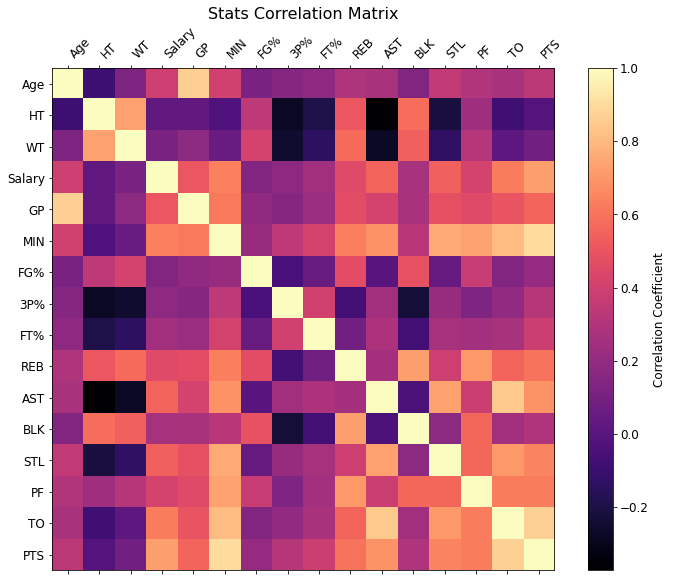

In [193]:
# plot the correlation matrix as a heatmap
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 9))
plt.matshow(stats_correlations, fignum=fig.number,cmap=plt.get_cmap('magma'))
plt.xticks(range(stats_correlations.shape[1]),stats_correlations.columns, fontsize=12,rotation=45,ha='left')
plt.yticks(range(stats_correlations.shape[1]),stats_correlations.columns, fontsize=12)
legend = plt.colorbar()
legend.ax.tick_params(labelsize=12)
legend.set_label('Correlation Coefficient',fontsize=12, )
plt.title('Stats Correlation Matrix', fontsize=16)

#### As you can see, there are many weak relationships (noise) that aren't worth spending our time on (e.g., the correlation between AST & PF). Also, some of the strong relationships are fairly obvious (e.g., the direct relationship between GP and Age, or Height and Weight).

#### A few pairs of metrics that are most highly correlated based on this matrix:
* Height and Weight
* Age and Games Played
* Minutes and most per-game stats, particularly Points Per Game
* Assists and Turnovers

#### There are also some pairs of metrics that have **negative** correlations:
* Height or Weight and 3P% / FT% / AST / STL
* Blocks Per Game and 3P% / FT%

#### As an experiment, let's determine the exact relationship between assists and turnovers

#### We can do this with a linear regression by removing `Null` entries and using the `sklearn.linear_model.LinearRegression` function

In [194]:
from sklearn.linear_model import LinearRegression

# remove rows with null values
ast_tov_df = all_players_df[['AST','TO']].dropna()

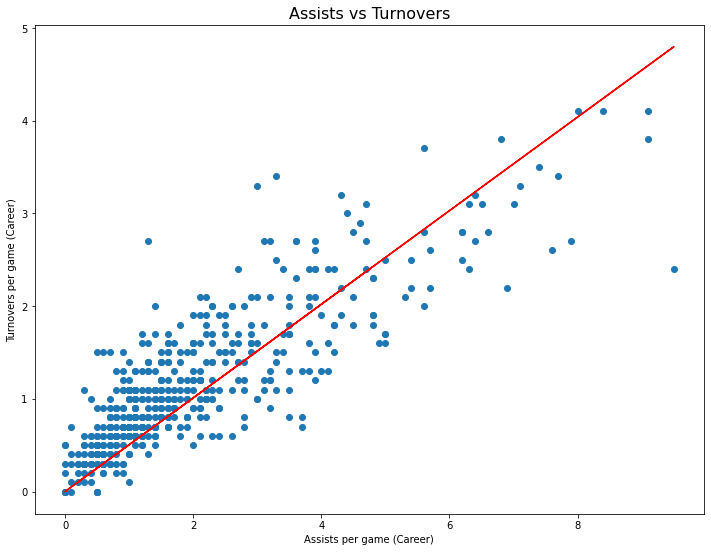

In [195]:
# fit a model with the independent (X) variable as AST, and the dependent (Y) variable as TO

X = ast_tov_df['AST'].values.reshape(-1,1)
Y = ast_tov_df['TO'].values.reshape(-1,1)
reg = LinearRegression(fit_intercept=False).fit(X,Y)
y_pred = reg.predict(X)
plt.figure(figsize=(12, 9))
plt.scatter(X, Y)
plt.plot(X, y_pred, color='red')
plt.xlabel("Assists per game (Career)")
plt.ylabel("Turnovers per game (Career)")
plt.title('Assists vs Turnovers', fontsize=16);

In [196]:
# get the slope of the line that characterizes this linear relationship

to_per_ast = reg.coef_[0][0]
to_per_ast

0.5049047499829297

#### From this information, we can see that an NBA player on average over a career has ~2 assists for every turnover they give up.

#### But what if we wanted to know what a 'good' ratio of AST to TO is for an NBA player?

#### If we add another column to our original dataframe, we can perform some quantile analysis to answer this question. Let's add an AST/TO column to our original dataframe.

In [197]:
# add calculated field

all_players_df['AST/TO'] = all_players_df['AST'] / all_players_df['TO']

In [225]:
# display new dataframe with added field

all_players_df.head(5)

,Name,POS,Age,HT,WT,College,Salary,Team,id,url,...,3P%,FT%,REB,AST,BLK,STL,PF,TO,PTS,AST/TO
Malcolm Brogdon,Malcolm Brogdon,PG,29,77.0,229.0,Virginia,21700000.0,boston-celtics,2566769,https://www.espn.com/nba/player/_/id/2566769/m...,...,37.6,88.1,4.2,4.8,0.2,0.9,1.9,1.8,15.5,2.666667
Jaylen Brown,Jaylen Brown,SG,25,78.0,223.0,California,26758928.0,boston-celtics,3917376,https://www.espn.com/nba/player/_/id/3917376/j...,...,37.3,71.2,4.9,2.0,0.4,0.9,2.5,1.9,16.5,1.052632
Bruno Caboclo,Bruno Caboclo,F,26,81.0,218.0,--,0.0,boston-celtics,3113297,https://www.espn.com/nba/player/_/id/3113297/b...,...,30.8,83.6,2.6,0.7,0.6,0.3,1.3,0.7,4.2,1.000000
JD Davison,JD Davison,G,19,75.0,195.0,Alabama,0.0,boston-celtics,4576085,https://www.espn.com/nba/player/_/id/4576085/j...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Danilo Gallinari,Danilo Gallinari,F,34,82.0,236.0,--,20475000.0,boston-celtics,3428,https://www.espn.com/nba/player/_/id/3428/dani...,...,38.2,87.7,4.8,1.9,0.4,0.7,1.8,1.2,15.6,1.583333


In [199]:
# pull out key percentile benchmarks for the AST/TO column

top_decile = round(all_players_df['AST/TO'].quantile(0.90),2)
top_quartile = round(all_players_df['AST/TO'].quantile(0.75),2)
median = round(all_players_df['AST/TO'].quantile(0.50),2)

print('The Median NBA player has ~{ratio} AST / TO through their career'.format(ratio=median))
print('A Top Quartile NBA player has ~{ratio} AST / TO through their career'.format(ratio=top_quartile))
print('A Top Decile NBA player has ~{ratio} AST / TO through their career'.format(ratio=top_decile))


The Median NBA player has ~1.58 AST / TO through their career
A Top Quartile NBA player has ~2.09 AST / TO through their career
A Top Decile NBA player has ~2.67 AST / TO through their career


#### You can see, from some simple dataframe manipulation (adding a calculated field) and existing pandas functions like `quartile` we can get a quick idea of what 'good' looks like for the AST/TO ratio of an NBA player across their career.

#### We could dive into advanced stats analysis, but we'll save that for another project. 

#### Lastly, I want to walk us through some of the machine learning capabilities of python, which allow us to develop predictive models based on what we know from the dataset we've compiled

## Part 3: Machine Learning

#### Let's get a quick idea what the rest of our dataset is like via a convenient python summary function

In [227]:
all_players_df.describe()

,Age,HT,WT,Salary,GP,MIN,FG%,3P%,FT%,REB,AST,BLK,STL,PF,TO,PTS,AST/TO
count,594.000000,594.000000,594.000000,5.900000e+02,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,511.000000
mean,25.351852,78.405724,215.146465,6.397128e+06,302.805447,21.020428,45.105642,31.310700,73.108949,3.804475,2.007393,0.438911,0.687938,1.777626,1.177237,9.338911,inf
std,5.021617,3.238476,23.756929,9.357576e+06,282.769789,8.318428,9.252481,9.742206,15.220464,2.241240,1.677585,0.401415,0.373867,0.695282,0.768335,5.510961,NaN
min,0.000000,69.000000,164.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,76.000000,197.000000,1.401945e+05,77.250000,15.300000,41.500000,30.000000,68.650000,2.200000,0.900000,0.200000,0.400000,1.325000,0.600000,5.400000,1.153947
50%,25.000000,78.000000,215.000000,2.086380e+06,202.000000,21.150000,44.600000,33.850000,75.900000,3.300000,1.500000,0.300000,0.700000,1.800000,1.000000,8.250000,1.583333
75%,29.000000,81.000000,230.000000,8.363832e+06,466.500000,27.900000,48.900000,36.500000,82.000000,4.900000,2.600000,0.600000,0.900000,2.200000,1.500000,12.600000,2.088933
max,42.000000,87.000000,290.000000,4.578097e+07,1366.000000,38.200000,100.000000,66.700000,100.000000,13.300000,9.500000,2.300000,2.100000,3.800000,4.100000,27.200000,inf


#### For most stats, there are a wide range of values across the entire NBA

#### Let's try and find two variables which have a non-linear relationship

#### For example, Age and Salary. We know players early in their career are signed to smaller contracts, then in their physical primes earn more, and eventually if they continue playing as they get older they will sign smaller veteran contracts again.

In [201]:
# drop all null rows for a clean dataset and sort in the order of the variable to be plotted along the x axis
ml_df = all_players_df.dropna().sort_values(by='Age',axis=0, ascending=True)

# specify the variables we will be fitting from the dataset
X = ml_df['Age'].values
Y = ml_df['Salary'].values

#### For reference, let's see how bad a linear fit would have been here

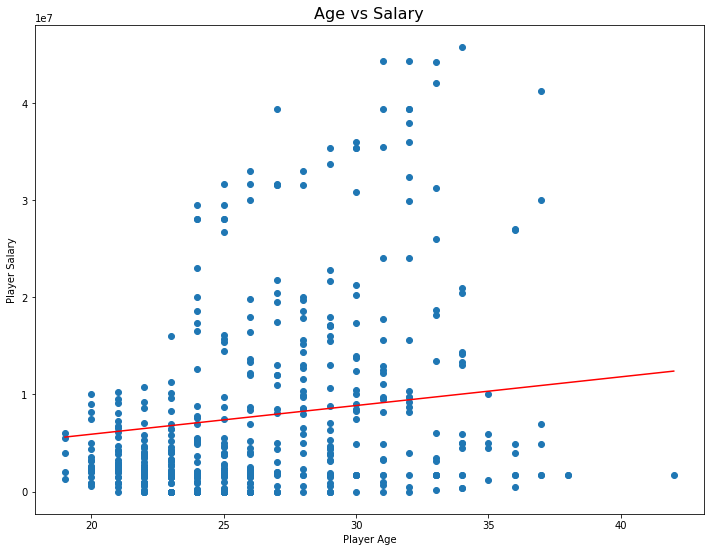

In [202]:
# define linear regression scatterplot for age vs. salary
X1 = ml_df['Age'].values
Y1 = ml_df['Salary'].values
reg1 = LinearRegression(fit_intercept=False).fit(X1.reshape(-1,1),Y1.reshape(-1,1))
y1_pred = reg1.predict(X1.reshape(-1,1))
plt.figure(figsize=(12, 9))
plt.scatter(X1, Y1)
plt.plot(X1, y1_pred, color='red')
plt.xlabel("Player Age")
plt.ylabel("Player Salary")
plt.title('Age vs Salary', fontsize=16);

In [203]:
# slope
reg1.coef_[0][0]

295212.57824411587

In [204]:
# intercept
reg1.intercept_

0.0

In [205]:
# get the R^2 of this relationship
reg1.score(X1.reshape(-1,1),Y1.reshape(-1,1))

0.07045312845897467

#### As evidenced by the extremely low R^2 <0.1, there is no clear linear relationship between player age and salary

#### Now let's look at the polynomial regression

In [206]:
# import libraries needed for polynomial regression
from sklearn.model_selection import train_test_split
import numpy as np

In [207]:
# split the dataset into training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=0)

In [208]:
# define the polynomial models
model1 = np.poly1d(np.polyfit(X_train, Y_train,1))
model2 = np.poly1d(np.polyfit(X_train, Y_train,2))
model3 = np.poly1d(np.polyfit(X_train, Y_train,3))
model6 = np.poly1d(np.polyfit(X_train, Y_train,6))

# predict output based on the fitted models (testing)
predictions1 = model1(np.sort(X_test))
predictions2 = model2(np.sort(X_test))
predictions3 = model3(np.sort(X_test))
predictions6 = model6(np.sort(X_test))

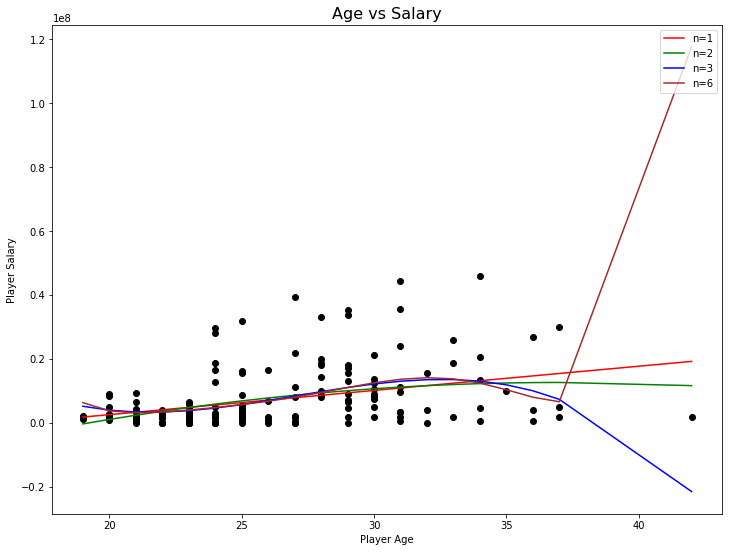

In [209]:
# plot the polynomial models against the test data
plt.figure(figsize=(12, 9))
plt.scatter(X_test, Y_test, c="#000000")
plt.plot(np.sort(X_test),predictions1, color='red', label="n=1")
plt.plot(np.sort(X_test),predictions2, color='green', label="n=2")
plt.plot(np.sort(X_test),predictions3, color='blue', label="n=3")
plt.plot(np.sort(X_test),predictions6, color='brown', label="n=6")
plt.xlabel("Player Age")
plt.ylabel("Player Salary")
plt.legend(loc='upper right')
plt.title('Age vs Salary', fontsize=16);

#### It is clear from the above that the degree of the polynomial to which we fit our data has a considerable impact on ouir predictions.

#### The first degree fit, as we had seen previously with the `LinearRegression`, is not a good fit.

#### The second degree fit is slightly better; however, we know it cannot be completely accurate as salary continues to increase with age even past 40

#### The third degree fit is better than both the first and second degree fits. We see a clear climb in salary with age to a point, and then a decrease beginning in a player's early 30's, which aligns with what we know to be true.

#### One might think that increasing the degree further will continue to improve the fit; however, that is not always the case. As evidenced by the 6th degree fit above, higher-degree polynomial fits can exhibit strange behaviors. For example, the 6th degree fit above shows that earnings for players <20 years old exceeds earningsfor players in their early 20s. It also shows that salary jumps quite rapidly for players in their late 30's and older. This misleading edge behavior is an example of **overfitting** in which the training data set used may be matched quite well, but the model becomes less useful for predicting outputs for new data.

#### In general, the work we've done here shows that there isn't really a clear polynomial relationship between age and salary. There are likely several other parameters that complicate this relationship.

#### If we wanted to analyze this more complex relationship, the `numpy poly1d` function would not be powerful enough to define that relationship. Instead, we would need to use `sklearn.preprocessing.PolynomialFeatures`. But I'll save that for another project given how long this notebook has become :)

### Thank you for reading this far! I hope you have found the content in this project interesting and potentially found this information useful for your own investigations. 

### Let me know if there are any other questions about NBA statistics and Python that you're curious to answer, and I'll see if I can address them in a future project.

#### Run the `espn_nba_stats_scrape.py` file in this repository to pull your own copy of the data we analyzed